<a href="https://colab.research.google.com/github/Sammm21/ML/blob/main/Bears.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bear** **Classifier**

Install dependencies and packages for fast ai to run in colab


In [1]:
# Run to make sure fastai runs in colab
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 8.3MB/s 
     |████████████████████████████████| 204kB 32.0MB/s 
     |████████████████████████████████| 51kB 9.5MB/s 
     |████████████████████████████████| 1.2MB 36.3MB/s 
     |████████████████████████████████| 61kB 10.2MB/s 
     |████████████████████████████████| 61kB 11.0MB/s 
Mounted at /content/gdrive


In [2]:
#hide
from fastbook import *

Link up Azure API key so you can download images from bing

In [3]:
# Azure API key
key = 'b324399406424e73b362094792ef8b55'

In [4]:
# Fastai function to dl images off bing
search_images_bing

<function fastbook.search_images_bing>

In [5]:
# Azure API uses contentUrl not content_url
# Get 150 images of bears off bing
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('contentUrl')
len(ims)

150

In [6]:
ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']
#os.path.abspath("images") 
#os.listdir("images")

We need to create the directory for the images in colab

In [7]:
# Make /images dir in colab
import os
os.mkdir('images')
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)

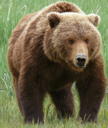

In [8]:
im = Image.open(dest)
im.to_thumb(128,128)

fastai download_images function will download all the URLs for each of our search terms. And if path doesn't exist then the function will make a directory for each of the bear types. So it will make a grizzly, black, and teddy directory and download and save images of the respective bear types in the respective directories.

In [9]:
bear_types = 'grizzly', 'black', 'teddy'
path = Path('bears')

if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

get_image_files() will show us the paths for our different directories and bears and how the images were saved therein

In [10]:
fns = get_image_files(path)
fns

(#396) [Path('bears/black/00000126.jpg'),Path('bears/black/00000087.jpg'),Path('bears/black/00000074.jpg'),Path('bears/black/00000027.jpg'),Path('bears/black/00000100.jpg'),Path('bears/black/00000148.jpg'),Path('bears/black/00000147.jpg'),Path('bears/black/00000005.jpg'),Path('bears/black/00000021.jpg'),Path('bears/black/00000068.jpg')...]

Often when we download files from the internet, there are a few that are corrupt. Let's check:


In [13]:
failed = verify_images(fns)
failed

(#4) [Path('bears/black/00000104.jpg'),Path('bears/black/00000032.jpg'),Path('bears/teddy/00000098.jpg'),Path('bears/grizzly/00000011.jpg')]


To remove all the failed images, you can use `unlink` on each of them. Note that, like most fastai functions that return a collection, `verify_images` returns an object of type `L`, which includes the `map` method. This calls the passed function on each element of the collection:

In [14]:
failed.map(Path.unlink)

FileNotFoundError: ignored

## **DataLoaders**

`DataLoaders` is a thin class that just stores whatever `DataLoader` objects you pass to it, and makes them available as `train` and `valid`. Although it's a very simple class, it's very important in fastai: it provides the data for your model. The key functionality in `DataLoaders` is provided with just these four lines of code:

```python
class DataLoaders(GetAttr):
    def __init__(self, *loaders): self.loaders = loaders
    def __getitem__(self, i): return self.loaders[i]
    train,valid = add_props(lambda i,self: self[i])
```

To turn our downloaded data into a DataLoaders object we need to tell fastai at least four things:


1.   What kinds of data we are working with
2.   How to get the list of items
3.   How to label these items
4.   How to create the validation set

We can do this with the DataBlock API:


*   The `get_image_files` function takes a path, and returns a list of all of the images in that path
*  The independent variable is often referred to as `x` and the dependent variable is often referred to as `y`  Here `get_y`  function labels the dependent variable
*   First we provide a tuple where we specify what types we want for the independent and dependent variables: The *independent variable* is the thing we are using to make predictions from, and the *dependent variable* is the target. The independent variable are the images of the bears and the dependent are the labels.
*   The images downloaded are all different sizes which poses a problem for deep learning: we don't feed the model one image at a time but several of them (what we call a mini-batch). In order to group them in a big array (a.k.a tensor) that is going to go through our model, they all need to be of the same size. The `item_tfms` will resize these images to the same size. Resizing it to 128x128. 

*   `splitter` splits the data into a training and validation set the proportion of data to be used for the validation set is set by `valid_pct` arguement , `seed` arguement ensure same random validation set used every time.  







In [15]:
bears = DataBlock(
    get_items = get_image_files,
    get_y = parent_label,
    blocks = (ImageBlock, CategoryBlock),
    item_tfms = Resize(128),
    splitter = RandomSplitter(valid_pct=0.3, seed=42))

The `DataBlock` object  is like a *template* for creating a `DataLoaders`. Next step is to specify the source of the data—in this case, the path where the images can be found:

In [16]:
dls = bears.dataloaders(path)

A `DataLoaders` includes validation and training `DataLoader`s. `DataLoader` is a class that provides batches of a few items at a time to the GPU. Looping through a `DataLoader` fastai will give you 64 items at a time, all stacked up into a single tensor. `show_batch` method on a `DataLoader` will show those items.

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


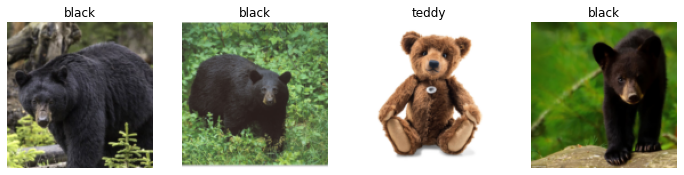

In [17]:
dls.valid.show_batch(max_n=4, nrows=1)

`Resize` *crops* the images to fit a square shape of the size requested, using the full width or height. This can result in losing some important details. `ResizeMethod.Squish` squishes the image but can result in some loss of information.

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


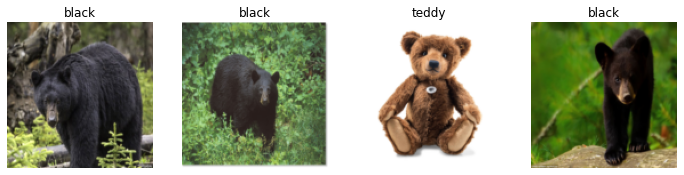

In [18]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

`ResizeMethod.Pad` adds padding to the borders that were squished so to preserve the originial proportions of the images.But adds some useless black non-information to the image.

"`All of these approaches seem somewhat wasteful, or problematic. If we squish or stretch the images they end up as unrealistic shapes, leading to a model that learns that things look different to how they actually are, which we would expect to result in lower accuracy. If we crop the images then we remove some of the features that allow us to perform recognition. For instance, if we were trying to recognize breeds of dog or cat, we might end up cropping out a key part of the body or the face necessary to distinguish between similar breeds. If we pad the images then we have a whole lot of empty space, which is just wasted computation for our model and results in a lower effective resolution for the part of the image we actually use.`"

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


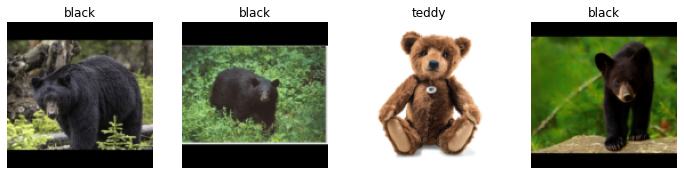

In [19]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

Instead, what we normally do in practice is to randomly select part of the image, and crop to just that part. On each epoch (which is one complete pass through all of our images in the dataset) we randomly select a different part of each image. This means that our model can learn to focus on, and recognize, different features in our images. It also reflects how images work in the real world: different photos of the same thing may be framed in slightly different ways.


Replacing `Resize` with `RandomResizedCrop` randomly selects part of the image and crops that part. `min_scale` arguement determines how much of the image to select at minimum each time:

We used `unique=True` to have the same image repeated with different versions of this `RandomResizedCrop` transform. This is a specific example of a more general technique, called data augmentation.

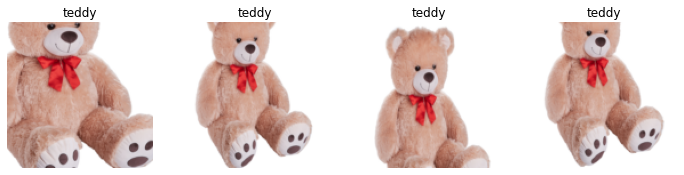

In [20]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)


## Data Augmentation



" *Data augmentation* refers to creating random variations of our input data, such that they appear different, but do not actually change the meaning of the data. Examples of common data augmentation techniques for images are rotation, flipping, perspective warping, brightness changes and contrast changes.

For natural photo images such as the ones we are using here, a standard set of augmentations that we have found work pretty well are provided with the `aug_transforms` function. 

Because our images are now all the same size, we can apply these augmentations to an entire batch of them using the GPU, which will save a lot of time. To tell fastai we want to use these transforms on a batch, we use the `batch_tfms` parameter (note that we're not using ``RandomResizedCrop`` in this example, so you can see the differences more clearly; we're also using double the amount of augmentation compared to the default, for the same reason):"


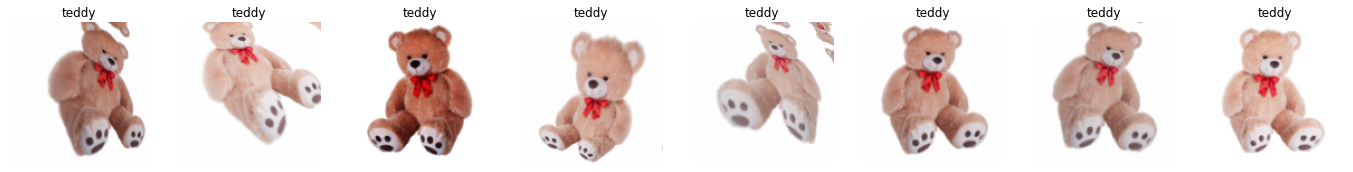

In [21]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=1, unique=True)

## Train The Model And Use It For Cleaning The Data

Train the model (`RandomResizedCrop` the images to 224 pixles and , which is fairly standard for image classification, and default `aug_transforms`) 

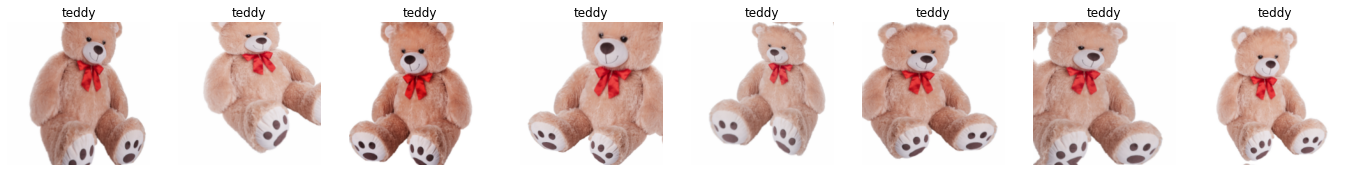

In [22]:
bears = bears.new(item_tfms=RandomResizedCrop(224, min_scale=0.5), batch_tfms=aug_transforms())
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=1, unique=True)

*   Specify transfer learner (data, architecture, metric)
*   Fine-tune the learner. 





In [23]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.660169,1.165663,0.333333,00:18


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,error_rate,time
0,0.204434,0.164963,0.068376,00:18
1,0.129768,0.047247,0.017094,00:18
2,0.099008,0.048210,0.008547,00:18
3,0.079780,0.049722,0.008547,00:18


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency e

Create confusion matrix to visualize classification results

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


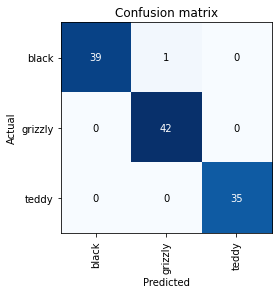

In [24]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

 `plot_top_losses` shows the images with the highest loss in the dataset. Output: prediction, actual (target label), loss, and probability. The *probability* here is the confidence level, from zero to one, that the model has assigned to its prediction:

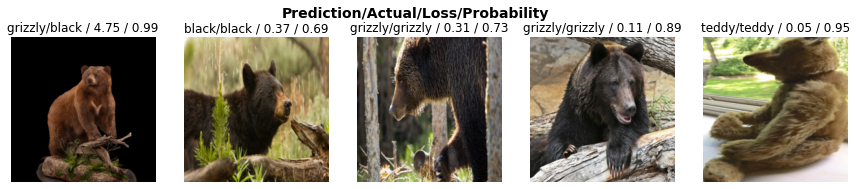

In [29]:
interp.plot_top_losses(5, nrows=1)

`ImageClassifierCleaner` allows you to choose a category and the training versus validation set and view the highest-loss images (in order), along with menus to allow images to be selected for removal or relabeling:

" `The intuitive approach to doing data cleaning is to do it *before* you train a model. But as you've seen in this case, a model can actually help you find data issues more quickly and easily. So, we normally prefer to train a quick and simple model first, and then use it to help us with data cleaning.` "

In [35]:
from fastai.vision.widgets import *
cleaner = ImageClassifierCleaner(learn)
cleaner

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


FileNotFoundError: ignored

`quote: No Need for Big Data: After cleaning the dataset using these steps, we generally are seeing 100% accuracy on this task. We even see that result when we download a lot fewer images than the 150 per class we're using here. As you can see, the common complaint that _you need massive amounts of data to do deep learning_ can be a very long way from the truth!`

Remove the wrong images through unlink and change the misclassified images to the correct classes:

In [36]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx, cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

FileNotFoundError: ignored


# **Turning** **The** **Model** **Into** **An** **Online** **Application**

Export the leaner.

In [37]:
learn.export()

Check that it was exported

In [38]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

Load the exported model/learner

In [39]:
learn_inf = load_learner(path/'export.pkl')

Use the learner to Predict Image

In [41]:
learn_inf.predict('images/grizzly.jpg')

('grizzly', tensor(1), tensor([5.2056e-07, 1.0000e+00, 1.0930e-08]))

List all possible classes of the learners outcome


In [42]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

# Creating A Notebook App From The Model, B

*IPython widgets* are GUI components that bring together JavaScript and Python functionality in a web browser, and can be created and used within a Jupyter notebook. For instance, the image cleaner is entirely written with IPython widgets.

*Voilà* exists is a system for making applications consisting of IPython widgets available, without having to use Jupyter. Voilà leverages the fact that a notebook _already is_ a kind of web application. Essentially, it automatically converts the complex web application (the notebook) into a web application.

Install voila for web application and ipywidgets for gui integrated widgets in jupyter notebooks:

In [43]:
!pip install voila
!jupyter serverextension enable voila --sys-prefix
!pip install ipywidgets

     |████████████████████████████████| 1.6MB 7.7MB/s 
     |████████████████████████████████| 389kB 51.6MB/s 
     |████████████████████████████████| 122kB 56.2MB/s 
     |████████████████████████████████| 552kB 52.9MB/s 
     |████████████████████████████████| 430kB 55.3MB/s 
     |████████████████████████████████| 81kB 11.7MB/s 
     |████████████████████████████████| 71kB 10.6MB/s 
ERROR: nbdev 1.1.14 has requirement nbconvert<6, but you'll have nbconvert 6.0.7 which is incompatible.
ERROR: google-colab 1.0.0 has requirement tornado~=5.1.0; python_version >= "3.0", but you'll have tornado 6.1 which is incompatible.
  Found existing installation: tornado 5.1.1
    Uninstalling tornado-5.1.1:
      Successfully uninstalled tornado-5.1.1
  Found existing installation: nbconvert 5.6.1
    Uninstalling nbconvert-5.6.1:
      Successfully uninstalled nbconvert-5.6.1
  Found existing installation: jupyter-client 5.3.5
    Uninstalling jupyter-client-5.3.5:
      Successfully uninstalled j

Enabling: voila
- Writing config: /usr/etc/jupyter
    - Validating...
Error loading server extension voila
      X is voila importable?


Create an upload button

In [68]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

Grab the image

In [74]:
img = PILImage.create(btn_upload.data[-1])

Use output widget to display it

In [71]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

Get predictions:

In [72]:
pred, pred_idx, probs = learn_inf.predict(img)

Use `label`to display predictions:

In [67]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: grizzly; Probability: 0.9978')

Create classification button:

In [73]:
btn_run = widgets.Button(description='Classify,B')
btn_run

Button(description='Classify,B', style=ButtonStyle())

Create *click event handler*; that is, a function that will be called when it's pressed:

In [64]:
def on_click_classify(change):
  img = PILImage.create(btn_upload.data[-1])
  out_pl.clear_output()
  with out_pl: display(img.to_thumb(128,128))
  pred, pred_idx, probs = learn_inf.predict(img)
  lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

Test the button by pressing it, and see the image and predictions update automatically!

We can now put them all in a vertical box (`VBox`) to complete our GUI:

In [65]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [75]:
VBox([widgets.Label('Select your bear!'),
      btn_upload, btn_run, out_pl, lbl_pred])